### Evolution of Stellar Kinematics in M33

In this notebook, I am answering the question: how will the velocity dispersion of M33 evolve during the M31-MW merger?

I will plot the evolution of the velociy dispersion over time.

In [1]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G
import astropy.table as tbl

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from Readfile import Read
from CenterOfMass import CenterOfMass

In [2]:
# make a class
class V_disp:
    # Class to compute the velocity and velocity dispersion of an input galaxy
    
    def __init__(self, galaxy, snap_id, ptype=2):
        
        """
        inputs: 
            galaxy: the name of the galaxy, input as string
            snap_id: the timestamp at which velocity is computed,
                     can be input as int or array of int
            ptype: the particle type whose velocity is computed
                    default: 2
                    1 for halo, 2 for stars, 3 for bulge
        """
        
            
        if snap_id < 9.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_00" + str(snap_id) + ".txt"
        elif snap_id < 99.9:
               self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_0" + str(snap_id) + ".txt"
        elif snap_id > 99.9:
              self.filename = "/home/astr400b/VLowRes/%s" %(galaxy) + "_" + str(snap_id) + ".txt"
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        #create an array to store indexes of particles of desired Ptype                                
        self.index = np.where(self.data['type'] == ptype)

        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m'][self.index]
        # write your own code to complete this for positions and velocities
        self.m = self.data["m"][self.index]
        self.x = self.data["x"][self.index]
        self.y = self.data["y"][self.index]
        self.z = self.data["z"][self.index]
        self.vx = self.data["vx"][self.index]
        self.vy = self.data["vy"][self.index]
        self.vz = self.data["vz"][self.index]
        
        
    def ReltoCoM(self):
        """
        function computes position and velocity of particles relative to their center of mass
        inputs: none, accepts inputs from __init__
        returns: 
            vtot: the total magnitude of the velocity vector
            vD: the 3-vector velocity
            rD: the 3-vector position
        """
        
        # Create instance of CenterOfMass of oobject
        COMD = CenterOfMass(self.filename,2)
        
        # Compute COM position and velocity using disk particles
        COMP = COMD.COM_P(0.1,4)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
        
        # Determine positions of particles relative to COM 
        xD = COMD.x - COMP[0] 
        yD = COMD.y - COMP[1]
        zD = COMD.z - COMP[2] 
        # 3-vector position 
        rD = np.array([xD, yD, zD])
        # total magnitude of the position vector
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)

        # Determine velocities of particles relative to COM motion
        vxD = COMD.vx - COMV[0]
        vyD = COMD.vy - COMV[1]
        vzD = COMD.vz - COMV[2]
        
        # 3-vector velocity
        vD = np.array([vxD, vyD, vzD])
        # total magnitude of velocity vector
        self.vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)
        
        return self.vtot, vD, rD

                    
    def velocity_dispersion(self, velocity):
        """
        function computes the velocity dispersion of particles
        inputs: velocity: the velocities whose dispersion you are computing
        returns: the velocity dispersion
        """
        # compute average velocity
        avg_v = np.sum(velocity)/(len(velocity))
        
        # create array of zeros
        v_disp = np.zeros_like(velocity)
        
        # compute (velocity dispersion)**2
        for i in range(len(velocity)):
            v_disp[i] = (velocity[i]-avg_v)**2
        v_disp = np.sqrt(np.sum(v_disp)/len(v_disp))
        
        # return average velocity and velocity dispersion
        return avg_v, v_disp
    

In [3]:
# as per Dr. Besla's reccomendation, a rotation


# a function that will rotate the position and velocity vectors
# so that the disk angular momentum is aligned with z axis. 

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction
    
    # transpose the inputs
    posI = posI.T
    velI = velI.T
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [4]:
M33_VDispersion = V_disp("M33",0)
M33_vtot, M33_vD, M33_rD = M33_VDispersion.ReltoCoM()
# I need to find the dimensions of the velocity arrays
print(M33_vD.shape)
M33_rotP, M33_rotV = RotateFrame(M33_rD, M33_vD)
print(M33_rotV.T.shape)

(3, 9300)
(3, 9300)


In [5]:
# compute mean velocity and velocity dispersion along a given axis:
snap_ids = np.arange(0,800,5)
M33_vD = np.zeros((len(snap_ids),3, 9300))
M33_vDisp = np.zeros((len(snap_ids),3))
M33_vAvg = np.zeros_like(M33_vDisp)
M33_vtot = np.zeros((len(snap_ids), 9300))
M33_rD = np.zeros_like(M33_vD)


for i in range(len(snap_ids)):
    n = snap_ids[i]
    M33_VDispersion = V_disp("M33",n)
    M33_vtot[i,:], M33_vD[i,:,:], M33_rD[i,:,:] = M33_VDispersion.ReltoCoM()
    M33_rotatedP, M33_rotatedV = RotateFrame(M33_rD[i,:,:], M33_vD[i,:,:])
    for j in range(3):
        
        M33_vAvg[i,j], M33_vDisp[i,j] = M33_VDispersion.velocity_dispersion(M33_rotatedV[:,j])
    



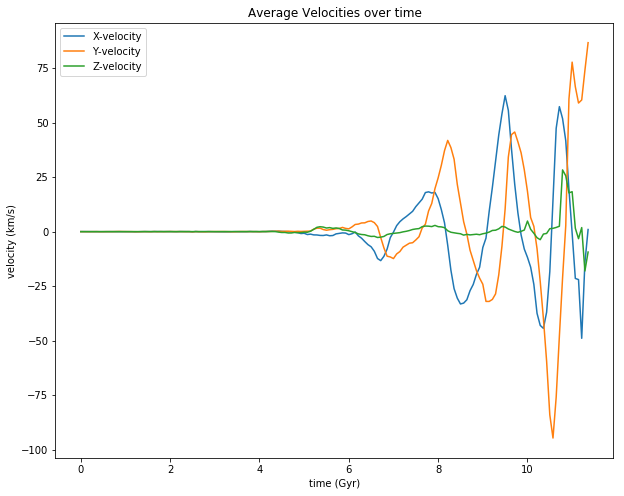

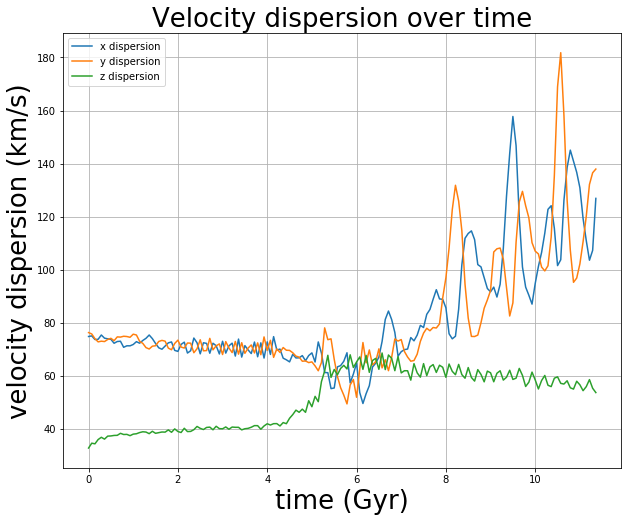

In [6]:
# read in from Orbit_M33.txt from assignment 6 to get the time
M33t, M33x, M33y, M33z, M33vx, M33vy, M33vz = np.genfromtxt("Orbit_M33.txt",delimiter=" ", unpack = True)
t = M33t[0:len(snap_ids)]/10e2
# plot the mean of the different velocity dimensions
plt.figure(figsize=(10,8))
plt.title("Average Velocities over time")
plt.xlabel("time (Gyr)")
plt.ylabel("velocity (km/s)")
plt.plot(t,M33_vAvg[:,0], label="X-velocity")
plt.plot(t, M33_vAvg[:,1], label="Y-velocity")
plt.plot(t, M33_vAvg[:,2], label="Z-velocity")
plt.legend()
plt.show()

# plot the velocity dispersion over time
plt.figure(figsize=(10,8))
plt.title("Velocity dispersion over time",fontsize=26,)
plt.ylabel("velocity dispersion (km/s)",fontsize=26)
plt.xlabel("time (Gyr)",fontsize=26)
plt.plot(t,M33_vDisp[:,0], label="x dispersion")
plt.plot(t,M33_vDisp[:,1], label="y dispersion")
plt.plot(t,M33_vDisp[:,2], label="z dispersion")
plt.legend()
plt.grid()
plt.show()


Assuming I did this correctly (which is assuming a lot), M33 becomes a kind of oblate spheroid elliptical

In [7]:
# doing everything above but not doing the frame rotation
i = 0
j = 0
for i in range(len(snap_ids)):
    n = snap_ids[i]
    M33_VDispersion = V_disp("M33",n)
    M33_vtot[i,:], M33_vD[i,:,:], M33_rD[i,:,:] = M33_VDispersion.ReltoCoM()

    for j in range(3):
        
        M33_vAvg[i,j], M33_vDisp[i,j] = M33_VDispersion.velocity_dispersion(M33_vD[i,j,:])
    


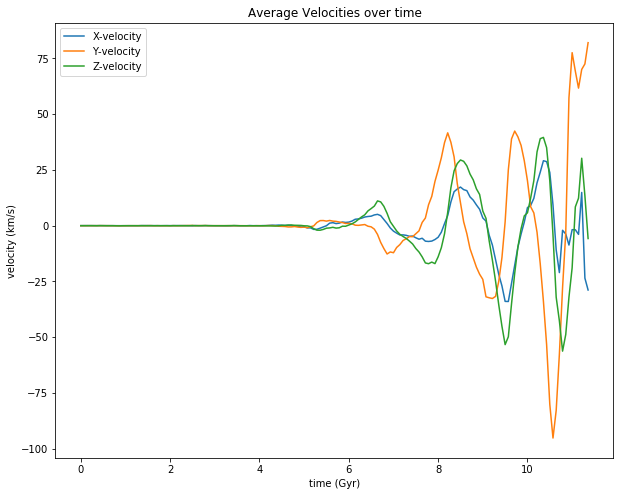

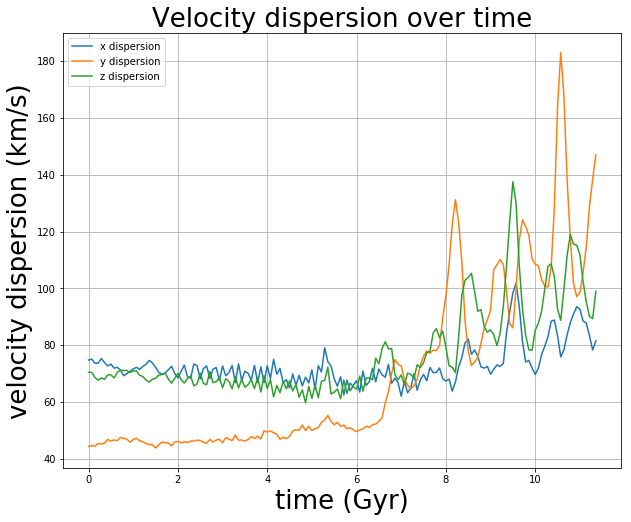

In [8]:
# plot the mean of the different velocity dimensions
plt.figure(figsize=(10,8))
plt.title("Average Velocities over time")
plt.xlabel("time (Gyr)")
plt.ylabel("velocity (km/s)")
plt.plot(t,M33_vAvg[:,0], label="X-velocity")
plt.plot(t, M33_vAvg[:,1], label="Y-velocity")
plt.plot(t, M33_vAvg[:,2], label="Z-velocity")
plt.legend()
plt.show()

# plot the velocity dispersion over time
plt.figure(figsize=(10,8))
plt.title("Velocity dispersion over time",fontsize=26,)
plt.ylabel("velocity dispersion (km/s)",fontsize=26)
plt.xlabel("time (Gyr)",fontsize=26)
plt.plot(t,M33_vDisp[:,0], label="x dispersion")
plt.plot(t,M33_vDisp[:,1], label="y dispersion")
plt.plot(t,M33_vDisp[:,2], label="z dispersion")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# need to compare peak mean velocity to velocity dispersion at that point
# that will give me info on the ellipticity of the galaxy
# compare to lecture 15

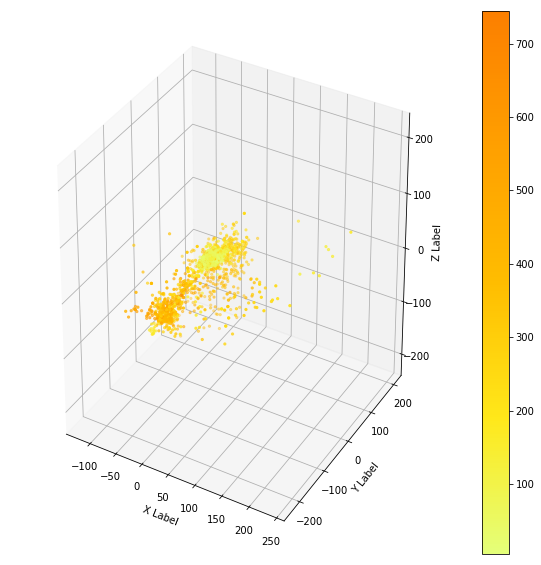

In [54]:
# here I play with plotting the galaxy

from mpl_toolkits.mplot3d import Axes3D


from pylab import *
fig = plt.figure(figsize=((10,10)))
ax = fig.add_subplot(111, projection='3d')

x = M33_rD[113,0,:]
y = M33_rD[113,1,:]
z = M33_rD[113,2,:]

# add colormap
color = M33_vtot[113,:]
# stuff for colormap I found on stackexchange
colmap = cm.ScalarMappable(cmap="Wistia")
colmap.set_array(color)


ax.scatter(x, y, z, c = color, marker='.', cmap="Wistia")
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(np.min(y),np.max(y))
ax.set_zlim(np.min(z),np.max(z))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
cb = fig.colorbar(colmap)

plt.show()
